# **College Basketball: An In-depth Study of the "Foul Up 3" Dilemma**

By: Julian Zapata-Hall

---

Below is the code for the analysis portion of my research project. Have allocated a specific folder within this project (Data/IntervalWinPercentages/ReproducedCalculations) to ensure reproducibility. This folder will store the results of the calculations you performed while running this notebook. Throughout this notebook, you will have the choice to continue with my original calculation results or the results you have previously generated.

### Installing all Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
%pip install sympy
%pip install pandas 
%pip install numpy
%pip install gdown
%pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Coding the 17 Up 3 Fouling Intervals

In [2]:
from sympy import Plane, Point2D, Line2D,Polygon, Segment
#This code creates a polygon for the last 20 seconds of the game clock
#x-axis corresponds with game clock times y-axis to shot clock times
#It also creates 8 lines that cut the polygon in such a way that
#generates the 17 two-dimensional time intervals of interest
origpolygon = Polygon([0, 0], [20, 0], [20,20], [0, 0])
line1 = Line2D([2,0],[2,2])
line2 = Line2D([5,0],[5,5])
line3 = Line2D([8,0],[8,8])
line4 = Line2D([11,0],[11,11])
line5 = Line2D([15,0],[15,15])
line6 = Line2D([2,0],[4,2])
line7 = Line2D([5,0],[35,30])
line8 = Line2D([11,0],[41 ,30])
up3segments = [origpolygon]
gone_over = [None]
for i in range(2):
  for line in [line1,line2,line3,line4,line5,line6,line7,line8]:
    for poli in up3segments:
      if ((poli,line) not in gone_over) and (poli!=None):
        try:
          segment = poli.cut_section(line)
          if None not in segment:
            up3segments.append(segment[0])
            up3segments.append(segment[1])
            up3segments.remove(poli)
          gone_over.append((poli,line))
        except:
          gone_over.append((poli,line))

### Win Percentage Calculating Functions


#### 1. Foul    AND   NOT(Foul)

In [3]:
import pandas as pd

def regularstrats_winper(in_df,line_list,point_list,polygon,margin,maxreg_secs,
                         minreg_secs,col_x='secs_left_half',col_y1='shot_clock',col_y2='exp_sc',
                         game_id_col='GameID',col_bonustype='BonusType'):
    """A function that calculates 1. the win percentage associated with performing a
    regular non-shooting foul and 2. the win percentage associated with not-fouling
      for a particular interval (given there was a chance to foul). """
    in_df['Polygon'] = polygon
    polygons =  in_df['Polygon'].values
    intersections1 = [str(polygons[i].intersection(line_list[i])) for i in range(len(in_df))]
    in_df['Intersection1'] = intersections1
    intersections2 = [str(polygons[i].intersection(point_list[i])) for i in range(len(in_df))]
    in_df['Intersection2'] = intersections2
    excluded_df = in_df.loc[(in_df['secs_left_reg']<=maxreg_secs)&
                            (in_df['secs_left_reg']>=minreg_secs-30)&
                            ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)&
                            ((in_df['TEAM_FOUL']=='no')|((in_df['TEAM_FOUL']=='yes')&
                                                         (in_df['Intersection2']=='[]')))&
                                                         (in_df['Intersection1']!='[]')].copy()

    df_clean11 = in_df[~in_df['FULLGAMEID'].isin(excluded_df['FULLGAMEID'])].copy()
    indf1 = df_clean11.loc[(df_clean11['TEAM_FOUL']=='yes')&(df_clean11['Intersection2']!='[]')&
                           ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)]
    df_clean12 = df_clean11[df_clean11['FULLGAMEID'].isin(indf1['FULLGAMEID'])].copy()
    df_clean21 = in_df[in_df['FULLGAMEID'].isin(excluded_df['FULLGAMEID'])].copy()
    indf2 = df_clean21.loc[(df_clean21['TEAM_FOUL']=='no')&(df_clean21['Intersection1']!='[]')&
                           ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)]
    df_clean22 = df_clean21[df_clean21['FULLGAMEID'].isin(indf2['FULLGAMEID'])].copy()

    gamesplayed_yes = len(df_clean12['FULLGAMEID'].unique())
    gameswon_yes = (df_clean12.groupby(['FULLGAMEID'])['team_win'].max()).sum()
    win_per_yes = gameswon_yes/gamesplayed_yes
    gamesplayed_no = len(df_clean22['FULLGAMEID'].unique())
    gameswon_no = (df_clean22.groupby(['FULLGAMEID'])['team_win'].max()).sum()
    win_per_no = gameswon_no/gamesplayed_no
    print('Strategic Fouling Area:', polygon)
    print('Win% Yes:', win_per_yes,'Win% No:', win_per_no)
    return polygon,[gameswon_yes,gamesplayed_yes,gameswon_no,gamesplayed_no]

#### 2. Foul + Additional Lane Violation   AND   NOT(Foul + Additional Lane Violation)

In [4]:
def laneviolationstrats_winper(in_df,line_list,point_list,polygon,margin,maxreg_secs,
                               minreg_secs,col_x='secs_left_half',col_y1='shot_clock',col_y2='exp_sc',
                               game_id_col='GameID',col_bonustype='BonusType'):
    """A function that calculates 1. the win percentage associated with performing a
    regular non-shooting foul and an additional lane violation and
    2. the win percentage associated with not-performing the lane violation approach
     for a particular interval
     (given there was a chance of performing the lane violation approach). """
    in_df['Polygon'] = polygon
    polygons =  in_df['Polygon'].values
    intersections1 = [str(polygons[i].intersection(line_list[i])) for i in range(len(in_df))]
    in_df['Intersection1'] = intersections1
    intersections2 = [str(polygons[i].intersection(point_list[i])) for i in range(len(in_df))]
    in_df['Intersection2'] = intersections2
    excluded_df = in_df.loc[(in_df['secs_left_reg']<=maxreg_secs)&
                            (in_df['secs_left_reg']>=minreg_secs-30)&
                            ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)&
                            ((in_df['BW_FOUL']=='no')|((in_df['BW_FOUL']=='yes')&(in_df['Intersection2']=='[]')))&
                            (in_df['Intersection1']!='[]')].copy()

    ##BW FOUL Is a short way to refer to foul + an additional lane violation
    ##BW are the initials of Bob Walsh CBB Coach credited with the fouling approach
    df_clean11 = in_df[~in_df['FULLGAMEID'].isin(excluded_df['FULLGAMEID'])].copy()
    indf1 = df_clean11.loc[(df_clean11['BW_FOUL']=='yes')&(df_clean11['Intersection2']!='[]')&
                           ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)]
    df_clean12 = df_clean11[df_clean11['FULLGAMEID'].isin(indf1['FULLGAMEID'])].copy()
    df_clean21 = in_df[in_df['FULLGAMEID'].isin(excluded_df['FULLGAMEID'])].copy()
    indf2 = df_clean21.loc[(df_clean21['BW_FOUL']=='no')&(df_clean21['Intersection1']!='[]')&
                           ((in_df['team_score'].shift() - in_df['opp_score'].shift())	== margin)]
    df_clean22 = df_clean21[df_clean21['FULLGAMEID'].isin(indf2['FULLGAMEID'])].copy()

    gamesplayed_yes = len(df_clean12['FULLGAMEID'].unique())
    gameswon_yes = (df_clean12.groupby(['FULLGAMEID'])['team_win'].max()).sum()
    win_per_yes = gameswon_yes/gamesplayed_yes
    gamesplayed_no = len(df_clean22['FULLGAMEID'].unique())
    gameswon_no = (df_clean22.groupby(['FULLGAMEID'])['team_win'].max()).sum()
    win_per_no = gameswon_no/gamesplayed_no
    print('Strategic Fouling Area:', polygon)
    print('Win% Yes:', win_per_yes,'Win% No:', win_per_no)
    return polygon,[gameswon_yes,gamesplayed_yes,gameswon_no,gamesplayed_no]

In [5]:
import numpy as np
import gdown
import warnings
warnings.filterwarnings('ignore')

##These urls correspond to the play by play data from the
##2009-10 and 2010-11 seasons, 2011-12 and 2012-13 seasons, 2013-14 seasons and 2014-15 seasons,
##2015-16 season, 2016-17 season, 2017-18 and 2018-19 seasons, 2019-20 and
##2020-21 and 2021-22 seasons of NCAA Division 1 Mens Basketball respectively.

urls = ['https://drive.google.com/file/d/1PxcGXvscaoaFPksHAabhLoIlxopsBUr3/view?usp=sharing',
        'https://drive.google.com/file/d/1qOgZ28TZTNUY4BjoeRZCnTGLUyTdDnIo/view?usp=sharing',
        'https://drive.google.com/file/d/1eUbCluRtm1NOZjSbQYR1EjkNs_hlR8pJ/view?usp=sharing',
        'https://drive.google.com/file/d/1_EELPYHrpTJVLJY_QkAESKa8w8EkPmzE/view?usp=sharing',
        'https://drive.google.com/file/d/1SC3yIfTWMp5Fe6lh-zzdssXFE3gFWY9e/view?usp=sharing',
        'https://drive.google.com/file/d/1k2mn1LQd2J1gA5f4vXlG62sxdDptD8HB/view?usp=sharing',
        'https://drive.google.com/file/d/152fSRK4ny7HD7so331YR2JzhPsjdXFEI/view?usp=sharing']



years = [2010,2012,2014,2016,2017,2018,2020] ##ordered years urls correspond to

##This analysis is time consuming and can take up to 9 hours to compute
##It was originally run in 14 different notebook files simultaneously, saving time.
##However, these files have been integrated to better display the analysis roadmap.
for u in range(len(urls)):
  url = urls[u]
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  pseudo_df = gdown.download(url, "current_pbp_file", quiet=False)
  pbp_data = pd.read_csv(pseudo_df)
  ##This  code corrects for overtime.
  ##If a game goes to OT 0.5 wins are assigned to each team.
  ##This reduces the effect of random noise on our calculated win percentages.
  pbp_data['half'] = (pbp_data['half'].astype(int))
  pbp_data['MAX_HALF'] = pbp_data.groupby(['FULLGAMEID'])['half'].transform(max)
  pbp_data['OT'] = pbp_data['MAX_HALF'] > 2
  pbp_data['team_win'] = [pbp_data['team_win'][i] if pbp_data['OT'][i] == False else .5 for i in range(len(pbp_data['OT']))]
  ##This code checks if there was an opportunity to commit a regular foul
  ##or an opportunity to commit a foul and a lane violation and
  ##creates a tag for if such a foul was committed.
  pbp_data['FTA'] = pbp_data['play_type'] =='free throw'
  pbp_data['Time'] = pbp_data['FULLGAMEID'] + pbp_data['FULLGAMEID'] + \
    pbp_data['half'].astype(str) + 'h' + pbp_data['secs_left_half'].astype(str)
  pbp_data['No. FTA'] = pbp_data.groupby('Time')['FTA'].transform('sum')
  pbp_data['FTA No.'] = pbp_data.groupby('Time')['FTA'].transform('cumsum')
  pbp_data['FTA1made'] = (pbp_data['FTA No.'] == 1)&(pbp_data['scoring_play']==1)
  pbp_data['FTA2made'] = (pbp_data['FTA No.'] == 2)&(pbp_data['scoring_play']==1)
  pbp_data['firstftmade'] = pbp_data.groupby('Time')['FTA1made'].transform('sum')
  pbp_data['secondftmade'] = pbp_data.groupby('Time')['FTA2made'].transform('sum')
  filters = [
        ((pbp_data['TEAM_FOUL']=='yes') &
          ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())	== 3))&
                                            ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())	== 3) &
                                            ((pbp_data['No. FTA']== 1)|(pbp_data['No. FTA']== 2)) & 
                                            ((pbp_data['firstftmade'] == 0)|(pbp_data['secondftmade'] == 1)),
      ((pbp_data['TEAM_FOUL']=='no') &
       ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())	== 3))|
       ((pbp_data['TEAM_FOUL']=='yes') & ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())	== 3) & 
        (pbp_data['No. FTA']== 2)& (pbp_data['firstftmade'] == 1)& (pbp_data['secondftmade']== 0))
  ]
  values = ["yes", "no"]
  ##BW FOUL Is a short way to refer to foul + an additional lane violation
  ##BW are the initials of Bob Walsh CBB Coach credited with the fouling approach
  pbp_data["BW_FOUL"] = np.select(filters, values, default="na")


  ##This code chunk stores every single play in the season (in the for loop)
  ##as a translation between two coordinates(game_clock_start,shot_clock_start)
  ## and (game_clock_end,shot_clock_end) as well as the end point.
  ##Namely, (game_clock_end,shot_clock_end) where start means start of the event,
  ##which corresponds which the aftermath of the last play and end which
  ##means the end of the event or
  ##the instant before the current event was recorded.

  ptmargin = 3
  polygons = up3segments
  max_gc = max([polygon.bounds[2] for polygon in polygons])
  lv_included_df =  pbp_data.loc[(pbp_data['secs_left_reg']<=max_gc)&
                                 ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())== ptmargin)&
                                 (pbp_data['half']==2)&((pbp_data['BW_FOUL']=='yes')|(pbp_data['BW_FOUL']=='no'))].copy()
  lv_df = pbp_data[(pbp_data['FULLGAMEID'].isin(lv_included_df['FULLGAMEID']))&
                   (pbp_data['secs_left_reg']<=max_gc)].copy()
  reg_included_df =  pbp_data.loc[(pbp_data['secs_left_reg']<=max_gc)&
                                  ((pbp_data['team_score'].shift() - pbp_data['opp_score'].shift())== ptmargin)&
                                  (pbp_data['half']==2)&
                                  ((pbp_data['TEAM_FOUL']=='yes')|(pbp_data['TEAM_FOUL']=='no'))].copy()
  reg_df = pbp_data[(pbp_data['FULLGAMEID'].isin(reg_included_df['FULLGAMEID']))&(pbp_data['secs_left_reg']<=max_gc)].copy()
  reg_lines = []##stores the traslations in the time plane for each play as a line segment
  reg_points = []##stores the game clock and shot clock times just before each event occurs
  for i in range(len(reg_df)):
    a = reg_df['secs_left_half'].shift().fillna(12000).values[i]
    b = reg_df['shot_clock'].shift().fillna(30).values[i]
    c = reg_df['secs_left_half'].values[i]
    d = reg_df['exp_sc'].values[i]
    if (a==c) and (b==d):
      reg_lines.append(Point2D(a,b))
    else:
      reg_lines.append(Segment(Point2D(a,b),Point2D(c,d)))
    reg_points.append(Point2D(c,d))
  reg_df['Lines']=reg_lines
  reg_df['Points']=reg_points
  lv_lines = []##stores the traslations in the time plane for each play as a line segment
  lv_points = []##stores the game clock and shot clock times just before each event occur
  for i in range(len(lv_df)):
    a = lv_df['secs_left_half'].shift().fillna(12000).values[i]
    b = lv_df['shot_clock'].shift().fillna(30).values[i]
    c = lv_df['secs_left_half'].values[i]
    d = lv_df['exp_sc'].values[i]
    if (a==c) and (b==d):
      lv_lines.append(Point2D(a,b))
    else:
      lv_lines.append(Segment(Point2D(a,b),Point2D(c,d)))
    lv_points.append(Point2D(c,d))
  lv_df['Lines']=lv_lines
  lv_df['Points']=lv_points


  ##This code chunk calculates games played and games won
  ##for each fouling approach associated
  ##with each of the given time intervals during this season (in the for loop)
  strats = [] ##stores the intervals in polygon format
  gws_foul_reg = []
  gps_foul_reg = []
  gws_nofoul_reg= []
  gps_nofoul_reg = []
  gws_foul_laneviolation = []
  gps_foul_laneviolation = []
  gws_nofoul_laneviolation = []
  gps_nofoul_laneviolation = []
  print('Up by '+str(ptmargin)+' scenario!')
  print('Start:')
  print()
  for i in range(len(polygons)):
    polygon = polygons[i]
    nmax_gc = polygon.bounds[2]
    nmin_gc = polygon.bounds[0]
    strat, [f_gw_reg,f_gp_reg,nf_gw_reg,nf_gp_reg] = regularstrats_winper(reg_df,reg_lines,
                                                                          reg_points,polygon,ptmargin,
                                                                          nmax_gc,nmin_gc)
    strat, [f_gw_lv,f_gp_lv,nf_gw_lv,nf_gp_lv] = laneviolationstrats_winper(lv_df,lv_lines,lv_points,
                                                                            polygon,ptmargin,
                                                                            nmax_gc,nmin_gc)
    strats.append(polygon)
    gws_foul_reg.append(f_gw_reg)
    gps_foul_reg.append(f_gp_reg)
    gws_nofoul_reg.append(nf_gw_reg)
    gps_nofoul_reg.append(nf_gp_reg)
    gws_foul_laneviolation.append(f_gw_lv)
    gps_foul_laneviolation.append(f_gp_lv)
    gws_nofoul_laneviolation.append(nf_gw_lv)
    gps_nofoul_laneviolation.append(nf_gp_lv)
    print()

  ##This code chunk creates and saves the within interval calculations for the
  ##regular and lane violation approaches in a reproduced calculations folder
  ##that way, there exist Original and Reproduced Calculations that can be
  ##compared to ensure verification and reproducibility.
  regular_resultdf = pd.DataFrame({'Strategy':strats,'Games Won Foul':gws_foul_reg,
                                   'Games Played Foul':gps_foul_reg,
                                   'Games Won NoFoul':gws_nofoul_reg,
                                   'Games Played NoFoul':gps_nofoul_reg})
  laneviolation_resultdf = pd.DataFrame({'Strategy':strats,
                                         'Games Won Foul':gws_foul_laneviolation,
                                         'Games Played Foul':gps_foul_laneviolation,
                                         'Games Won NoFoul':gws_nofoul_laneviolation,
                                         'Games Played NoFoul':gps_nofoul_laneviolation})
  regular_resultdf.to_csv('./Data/IntervalWinPercentages/ReproducedCalculations/rep_reg_pbp_'+
                          str(years[u])+'_results.csv',index=False)
  laneviolation_resultdf.to_csv('./Data/IntervalWinPercentages/ReproducedCalculations/rep_lv_pbp_'+
                                str(years[u])+'_results.csv',index=False)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1PxcGXvscaoaFPksHAabhLoIlxopsBUr3
From (redirected): https://drive.google.com/uc?id=1PxcGXvscaoaFPksHAabhLoIlxopsBUr3&confirm=t&uuid=854ac0c9-0e9e-4a4e-a764-453f92dadc1c
To: /Users/julianzapata-hall/Documents/NCAAUp3Fouling/current_pbp_file
100%|██████████| 944M/944M [01:07<00:00, 14.0MB/s] 


Up by 3 scenario!
Start:

Strategic Fouling Area: Triangle(Point2D(0, 0), Point2D(2, 0), Point2D(2, 2))
Win% Yes: 0.8846153846153846 Win% No: 0.9556962025316456
Strategic Fouling Area: Triangle(Point2D(0, 0), Point2D(2, 0), Point2D(2, 2))
Win% Yes: 1.0 Win% No: 0.9561128526645768

Strategic Fouling Area: Polygon(Point2D(5, 3), Point2D(5, 5), Point2D(2, 2), Point2D(2, 0))
Win% Yes: 0.95 Win% No: 0.9445910290237467
Strategic Fouling Area: Polygon(Point2D(5, 3), Point2D(5, 5), Point2D(2, 2), Point2D(2, 0))
Win% Yes: 1.0 Win% No: 0.9450127877237852

Strategic Fouling Area: Triangle(Point2D(2, 0), Point2D(5, 0), Point2D(5, 3))
Win% Yes: nan Win% No: 1.0
Strategic Fouling Area: Triangle(Point2D(2, 0), Point2D(5, 0), Point2D(5, 3))
Win% Yes: nan Win% No: 1.0

Strategic Fouling Area: Polygon(Point2D(11, 9), Point2D(11, 11), Point2D(8, 8), Point2D(8, 6))
Win% Yes: 0.7777777777777778 Win% No: 0.9244791666666666
Strategic Fouling Area: Polygon(Point2D(11, 9), Point2D(11, 11), Point2D(8, 8), Point

## Graphing Fouling Approaches

### Empty Grid Graph

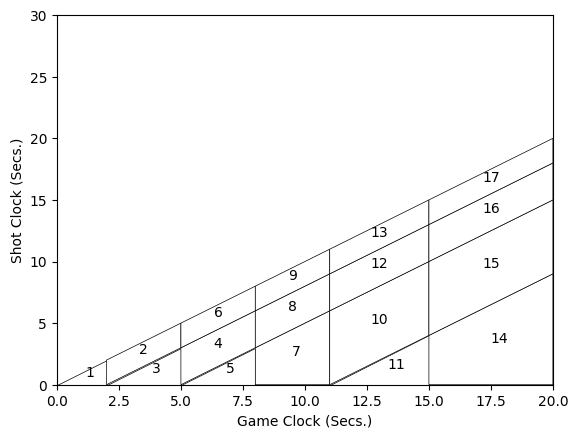

In [ ]:
from sympy import Plane, Point2D, Line2D,Polygon, Segment,Triangle
import matplotlib.pyplot as plt

maxx = 20

fig, ax = plt.subplots(1,1)
grouped = pd.read_csv('./Data/IntervalsBaseGraph/polygon_graph.csv')

grouped['Centroid (GC,SC)'] = [(eval(x).centroid) for x in grouped['Strategy']]
grouped['Polygon No.'] = grouped.index+1
for idx, row in grouped.iterrows():
  plt.annotate(text=row['Polygon No.'], xy=row['Centroid (GC,SC)'],horizontalalignment='center',size=10)

gp_count=0
gw_count=0
from matplotlib.patches import Polygon

for i in range(len(grouped.reset_index()['Strategy'])):
  poli = eval(grouped.reset_index()['Strategy'][i].replace('Polygon(','Polygon([').
              replace('Triangle(','Polygon([').replace('))',')])').replace('Point2D(','('))
  ax.set_facecolor('w')
  Polygon.set_color(poli,c='w')
  Polygon.set_edgecolor(poli,color='k')
  Polygon.set_linewidth(poli,w=.5)
  Polygon.set_label(poli,s=str(i))
  ax.add_patch(poli)
plt.ylim(0,30)
plt.xlim(0,maxx)
ax.set_xlabel('Game Clock (Secs.)')
ax.set_ylabel('Shot Clock (Secs.)')

plt.show()

### Calculated Recommendations Across Intervals

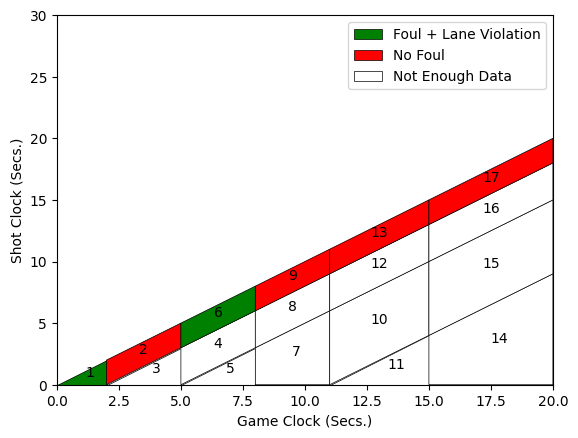

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import Plane, Point2D, Line2D,Polygon, Segment,Triangle

ptmargin=3
bonustype = 'double'
maxx = 20

##Do you wish to graph my Original Calculations or your Reproduced Calculations?
restype ='orig'
folder ='StudyCalculations'

#restype ='rep'
#folder ='ReproducedCalculations'

reg_res_2010 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2010_results.csv')
reg_res_2012 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2012_results.csv')
reg_res_2014 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2014_results.csv')
reg_res_2016 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2016_results.csv')
reg_res_2017 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2017_results.csv')
reg_res_2018 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2018_results.csv')
reg_res_2020 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_reg_pbp_2020_results.csv')
lv_res_2010 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2010_results.csv')
lv_res_2012 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2012_results.csv')
lv_res_2014 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2014_results.csv')
lv_res_2016 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2016_results.csv')
lv_res_2017 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2017_results.csv')
lv_res_2018 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2018_results.csv')
lv_res_2020 = pd.read_csv('./Data/IntervalWinPercentages/'+folder+'/'+restype+'_lv_pbp_2020_results.csv')


##This code chunk joins all the above datasets and calculates win percentages associated with each approach.
reg_results = pd.concat([reg_res_2010,reg_res_2012,reg_res_2014,
                         reg_res_2016,reg_res_2017,reg_res_2018,reg_res_2020],ignore_index=True)
lv_results = pd.concat([lv_res_2010,lv_res_2012,lv_res_2014,lv_res_2016,
                         lv_res_2017, lv_res_2018, lv_res_2020],ignore_index=True)
reg_results['idx']=reg_results.index
lv_results['idx']=lv_results.index
results = reg_results.join(lv_results,on='idx', rsuffix=" LV")
grouped = results.groupby(['Strategy']).sum()
grouped['Win% LVFoul'] = (100*grouped['Games Won Foul LV']) / grouped['Games Played Foul LV']
grouped['Win% NoLVFoul'] =(100*grouped['Games Won NoFoul LV']) / grouped['Games Played NoFoul LV']
grouped['Win% RegFoul'] = (100*grouped['Games Won Foul']) / grouped['Games Played Foul']
grouped['Win% NoFoul'] =(100*grouped['Games Won NoFoul']) / grouped['Games Played NoFoul']
grouped.reset_index(inplace=True)
grouped['MinGC'] = [eval(x).bounds[0] for x in grouped['Strategy']]
grouped['MinSC'] = [eval(x).bounds[1] for x in grouped['Strategy']]
grouped['Centroid (GC,SC)'] = [(eval(x).centroid) for x in grouped['Strategy']]
grouped.sort_values(['MinGC','MinSC'], ascending=True, inplace=True, ignore_index=True)
grouped['Polygon No.'] = grouped.index+1
grouped.to_csv('results.csv',index=False)

##This code chunk graphs the recommended approaches for each interval.
##It compares the win percentages across all fouling decisions and
##colors the plain grid according to the best approach in each interval.
##Red = NO FOUL, Green=Foul+LaneViolation, White=NotEnoughData
from matplotlib.patches import Polygon
next_wp_nofoul = 10000
fig, ax = plt.subplots(1,1)
for idx, row in grouped.iterrows():
  plt.annotate(text=row['Polygon No.'], xy=row['Centroid (GC,SC)'],
                 horizontalalignment='center',size=10)
for i in range(len(grouped.reset_index()['Strategy'])):
  poli = eval(grouped.reset_index()['Strategy'][i].replace('Polygon(','Polygon([').
              replace('Triangle(','Polygon([').replace('))',')])').replace('Point2D(','('))
  ax.set_facecolor('w')
  wp_lvfoul = grouped['Win% LVFoul'].values[i]
  wp_regfoul = grouped['Win% RegFoul'].values[i]
  wp_nofoul = grouped['Win% NoFoul'].values[i]
  gp_lvfoul = grouped['Games Played Foul LV'].values[i]
  gp_regfoul = grouped['Games Played Foul'].values[i]
  gp_nofoul = grouped['Games Played NoFoul'].values[i]
  if gp_regfoul <50:
    Polygon.set_color(poli,c='w')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    Polygon.set_label(poli,s='Not Enough Data')
    ax.add_patch(poli)
  elif wp_regfoul>wp_nofoul and wp_regfoul>wp_lvfoul:
    Polygon.set_color(poli,c='y')
    Polygon.set_edgecolor(poli,color='k')

    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='Regular Foul')
  elif wp_lvfoul>wp_nofoul and wp_lvfoul>wp_regfoul:
    Polygon.set_color(poli,c='g')
    Polygon.set_edgecolor(poli,color='k')

    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='Foul + Lane Violation')
  elif wp_nofoul>wp_lvfoul and wp_nofoul>wp_regfoul:
    Polygon.set_color(poli,c='r')
    Polygon.set_edgecolor(poli,color='k')

    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='No Foul')
  else:
    Polygon.set_color(poli,c='b')
    Polygon.set_edgecolor(poli,color='k')

    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s="Non Conclusive Result")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0,30)
plt.xlim(0,maxx)
ax.set_xlabel('Game Clock (Secs.)')
ax.set_ylabel('Shot Clock (Secs.)')
plt.show()

## Important Technical Basketball Considerations

### A correction must be made on Interval Number 1

When calculating the win percentage for these intervals, I made a critical assumption. I only considered non-shooting fouls. This allowed me to compare the different fouling approaches over time. However, there is a small issue. Interval number 1 recommends fouling, however, this is a non-coachable strategy for that given interval. In the current state of NCAA basketball, it is physically impossible for a player to commit a non-shooting foul reliably in interval number 1. Additionally, committing a shooting foul in that interval would effectively cost the fouling team the win. Since there is not enough control to guarantee that this approach will be possible, and there are grave consequences associated with committing a shooting foul in this interval, I made the decision to move recommend "not fouling" for this time interval.

### Filling the Other Intervals

The threshold I set for performing statistical analysis on any given interval was that there must have been at least 50 non-shooting regular fouls committed in that interval over 13 seasons of college basketball. Although this does not seem high at first thought, it has eliminated most of the intervals. Even if it is reduced significantly, most intervals do not have associated recommendations. 

The importance of subject matter knowledge in this stage is critical. Fouling in interval 3 is equivalent in basketball terms to fouling in interval 2 as are intervals 4,5,6 and so on. The win percentages associated will be the same. Thus, for the other intervals, the win percentage associated with not fouling was compared to that of regular fouling and fouling with an additional lane violation with a maximum shot clock value. This analysis shows that intervals 4,7,10 have instances in which fouling is beneficial. However, as noted in the correction for interval number one. When the shot clock is winding down, there are grave consequences associated with committing a shooting foul . Thus, I have considered these non-fouling intervals. For all other intervals, fouling should also be avoided.

### The Viability of the Regular Foul + Lane Violation Approach

Regular fouling is mostly unsupported when up by 3. Lane Violation strategy is superior as it obtains the ball back. However, due to the current NCAA college basketball rulebook the additional lane violation approach is only beneficial if employed by the team with the possession arrow in their favor. Thus, I divide the strategy into two distinct sections.

# Graphing Resulting Up 3 Fouling Strategy

## Recommended Strategy: Leading Team has Possession Arrow

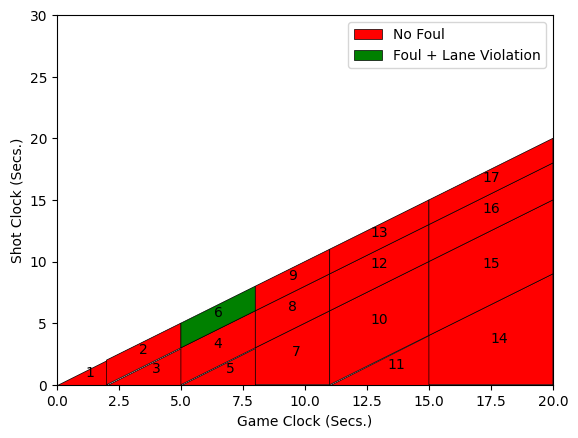

In [ ]:
import pandas as pd
import numpy as np
from sympy import Plane, Point2D, Line2D,Polygon, Segment,Triangle
import matplotlib.pyplot as plt

maxx = 20

fig, ax = plt.subplots(1,1)
grouped = pd.read_csv('./Data/IntervalsBaseGraph/polygon_graph.csv')

grouped['Centroid (GC,SC)'] = [(eval(x).centroid) for x in grouped['Strategy']]
grouped['Polygon No.'] = grouped.index+1
for idx, row in grouped.iterrows():
  plt.annotate(text=row['Polygon No.'], xy=row['Centroid (GC,SC)'],horizontalalignment='center',size=10)

gp_count=0
gw_count=0
from matplotlib.patches import Polygon

for i in range(len(grouped.reset_index()['Strategy'])):
  poli = eval(grouped.reset_index()['Strategy'][i].replace('Polygon(','Polygon([').
              replace('Triangle(','Polygon([').replace('))',')])').replace('Point2D(','('))
  if i ==0:
    Polygon.set_color(poli,c='r')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='No Foul')
  elif i in [5]:
    Polygon.set_color(poli,c='g')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='Foul + Lane Violation')
  else:
    Polygon.set_color(poli,c='r')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='')
plt.ylim(0,30)
plt.xlim(0,maxx)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlabel('Game Clock (Secs.)')
ax.set_ylabel('Shot Clock (Secs.)')
plt.show()

## Recommended Strategy: Trailing Team has Possession Arrow

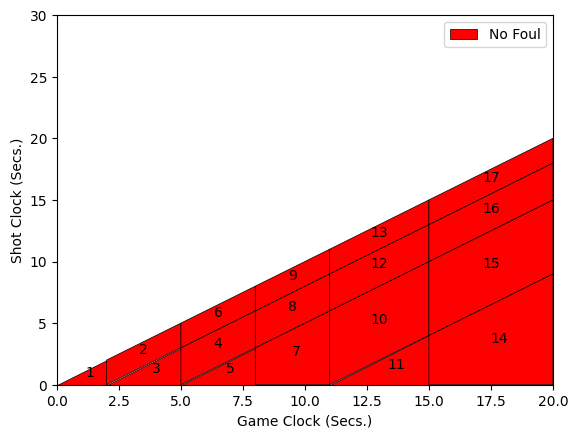

In [ ]:
import pandas as pd
import numpy as np
from sympy import Plane, Point2D, Line2D,Polygon, Segment,Triangle
import matplotlib.pyplot as plt

maxx = 20

fig, ax = plt.subplots(1,1)
grouped = pd.read_csv('./Data/IntervalsBaseGraph/polygon_graph.csv')

grouped['Centroid (GC,SC)'] = [(eval(x).centroid) for x in grouped['Strategy']]
grouped['Polygon No.'] = grouped.index+1
for idx, row in grouped.iterrows():
  plt.annotate(text=row['Polygon No.'], xy=row['Centroid (GC,SC)'],horizontalalignment='center',size=10)

gp_count=0
gw_count=0
from matplotlib.patches import Polygon

for i in range(len(grouped.reset_index()['Strategy'])):
  poli = eval(grouped.reset_index()['Strategy'][i].replace('Polygon(','Polygon([').
              replace('Triangle(','Polygon([').replace('))',')])').replace('Point2D(','('))
  if i ==0:
    Polygon.set_color(poli,c='r')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='No Foul')
  else:
    Polygon.set_color(poli,c='r')
    Polygon.set_edgecolor(poli,color='k')
    Polygon.set_linewidth(poli,w=.5)
    ax.add_patch(poli)
    Polygon.set_label(poli,s='')
plt.ylim(0,30)
plt.xlim(0,maxx)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax.set_xlabel('Game Clock (Secs.)')
ax.set_ylabel('Shot Clock (Secs.)')
plt.show()

## Resulting Fouling Strategy Description

 The resulting fouling approach for a team up by 3 is as follows: If the possession arrow points toward the trailing team, the leading team should avoid fouling. Furthermore, if the possession arrow points toward the leading team, they should only foul and perform a lane violation with 5 to 8 seconds remaining on the game clock and at most a 2-second difference between the shot clock and game clock.

## Concluding Statements


Through my analysis, I have been able to generate a fouling strategy for up by 3 that any college can implement. Moreover, by using a new variable that had not previously been employed and an extensive amount of game data, I have been able to shine light on the most debated question within strategic fouling. Although this set of results should not be applied outside of the scope of NCAA college basketball, a similar project could elevate the level of fouling strategy within the NBA or any other basketball league around the world.



## Acknowledgments

Thank you to these great people and their constant feedback, validation and overall support:

- Bob Walsh (college coach, St John’s Red Storm)
- Chris Murphy (college coach, Union College Garnet Chargers)
- Dr. Roger Hoerl (statistician, Union College)
- Dr. Sebastian Kurtek (statistician, The Ohio State University)
- Dr. Wayne Winston (statistician, Indiana University)
- Ken Pomeroy (statistician, kenpom.com)
- Kevin Weckworth (college coach, Hartford Hawks)
- Matthew Droney (college coach, Babson Beavers)
- Patrick Doherty (college coach, Haverford Fords)
- Phil Martelli Jr. (college coach, Bryant Bulldogs)
- Steve Merfeld (college coach, Creighton Bluejays)